### === Task ===

1. With the iris data given in class, implement train_test_split from scratch.

2. Put everything into a class called LogisticRegression, this class should allow you choose any of the training methods you'd like including "batch", "minibatch" and "sto". However, if the input method is not one of the three, it should "raise ValueError".

3. Calculate time taken to fit your models using different training methods.

4. Perform a classification on the dataset using all 3 methods and also show what happens if your defined training method is not either "batch", "minibatch" or "sto". Make sure to plot the training losses.

5. Simply, use classification_report from sklearn.metrics to evaluate your models.

6. Discuss your results ie. training losses of the three methods and time taken to fit models.

In [19]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from time import time

# import some data
iris = datasets.load_iris()
X = iris.data[:, 2:]
y = iris.target

# Shuffle
data = np.concatenate((X, y.reshape(-1,1)), axis=1)
rng = np.random.default_rng()
rng.shuffle(data)
X = data[:,:-1]
y = data[:,-1]

# feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# data split
train_size = round(70/100 * X.shape[0])
X_train = X[:train_size, :]
Y_train = y[:train_size]
X_test = X[train_size:,:]
Y_test = y[train_size:]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# add intercept to our X
intercept = np.ones((X_train.shape[0], 1))
X_train   = np.concatenate((intercept, X_train), axis=1)
intercept = np.ones((X_test.shape[0], 1))
X_test    = np.concatenate((intercept, X_test), axis=1)

k = len(set(y))
m = X_train.shape[0]
n = X_train.shape[1]
Y_train_encoded = np.zeros((m, k))
for each_class in range(k):
    cond = Y_train==each_class
    Y_train_encoded[np.where(cond), each_class] = 1

(105, 2)
(105,)
(45, 2)
(45,)


In [20]:
class LogisticRegression:
    def __init__(self, method="minibatch", max_iter=10000, l_rate=0.001, batch_size_ratio=0.1):
        if (method != "minibatch") & (method != "batch") & (method != "sto"):
            raise ValueError("Method is not match")
        else:
            self.method = method
            self.max_iter = max_iter
            self.l_rate = l_rate
            self.batch_size_ratio = batch_size_ratio

    def fit(self, X, Y):
        m = X.shape[0]
        n = X.shape[1]
        k = Y.shape[1]
        self.W = np.random.rand(n, k)
        batch_size = round(self.batch_size_ratio*m)
        self.losses = []
        list_of_used_ix = []
        start = time()
        for i in range(self.max_iter):
            if self.method == "minibatch":
                idx = np.random.randint(0, m-batch_size)
                X_batch = X[idx:idx+batch_size]
                Y_batch = Y[idx:idx+batch_size]
            elif self.method == "batch":
                X_batch = X
                Y_batch = Y
            elif self.method == "sto":
                idx = np.random.randint(X_train.shape[0])
                while idx in list_of_used_ix:
                    idx = np.random.randint(X_train.shape[0])
                X_batch = X[idx, :].reshape(1, -1)
                Y_batch = Y_train_encoded[idx]                
                list_of_used_ix.append(idx)
                if len(list_of_used_ix) == X_train.shape[0]:
                    list_of_used_ix = []
            cost, grad =  self.gradient(X_batch, Y_batch)
            self.losses.append(cost)
            self.W = self.W - self.l_rate * grad
        self.runtime = time()-start

    def gradient(self, X, Y):
        m = X.shape[0]
        h = self.h_theta(X, self.W)
        cost = - np.sum(Y * np.log(h)) / m
        error = h - Y
        grad = self.softmax_grad(X, error)
        return cost, grad

    def softmax_grad(self, X, error):
        return  X.T @ error
            
    def softmax(self, theta_t_x):
        return np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True)

    def h_theta(self, X, W):
        return self.softmax(X @ W)
    
    def predict(self, X):
        return np.argmax(self.h_theta(X, self.W), axis=1)

    def plot_losses(self):
        x_axis = [*range(len(self.losses))]
        y_axis = self.losses
        plt.plot(x_axis, y_axis)
        title = "Losses - iteration " + "("+self.method+")"
        plt.title(title)
        plt.xlabel("Iteration")
        plt.ylabel("Losses")

***** Minibatch *****
Time:  0.3114960193634033
*************** Classification Report ***************
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       1.00      0.92      0.96        12
         2.0       0.95      1.00      0.97        18

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45



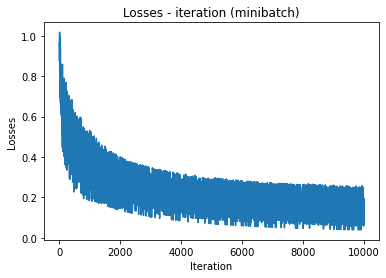

In [21]:
from sklearn.metrics import classification_report

print("***** Minibatch *****")
model_mini = LogisticRegression(method="minibatch")
model_mini.fit(X_train, Y_train_encoded)
print("Time: ", model_mini.runtime)
print("*************** Classification Report ***************")
yhat = model_mini.predict(X_test)
print(classification_report(Y_test, yhat))
model_mini.plot_losses()

***** Batch *****
Time:  0.334578275680542
*************** Classification Report ***************
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       1.00      0.92      0.96        12
         2.0       0.95      1.00      0.97        18

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45



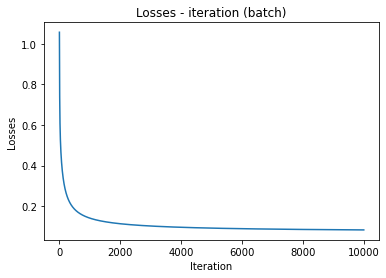

In [22]:
print("***** Batch *****")
model_batch = LogisticRegression(method="batch")
model_batch.fit(X_train, Y_train_encoded)
print("Time: ", model_batch.runtime)
print("*************** Classification Report ***************")
yhat = model_batch.predict(X_test)
print(classification_report(Y_test, yhat))
model_batch.plot_losses()

***** Stochastic *****
Time:  0.4622769355773926
*************** Classification Report ***************
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        15
         1.0       1.00      0.83      0.91        12
         2.0       0.95      1.00      0.97        18

    accuracy                           0.96        45
   macro avg       0.96      0.94      0.95        45
weighted avg       0.96      0.96      0.95        45



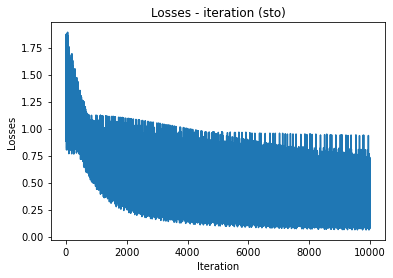

In [23]:
print("***** Stochastic *****")
model_sto = LogisticRegression(method="sto")
model_sto.fit(X_train, Y_train_encoded)
print("Time: ", model_sto.runtime)
print("*************** Classification Report ***************")
yhat = model_sto.predict(X_test)
print(classification_report(Y_test, yhat))
model_sto.plot_losses()

### Discussion about compairson between the three methods
* Time taken of the 3 methods are quite similar espectially "Batch" method and "Minibatch" method because size of data is quite small. Therefore minibatch method cannot not decrease the time significantly. In case of stochastic method, the time is pretty higher that the others because of the random algorithm that it try to random a new sample and it must not the same as previous samples.
* For the losses graph, losses from minibatch method and stochastic method are very fluctuate because the gradient is from some data. On the other hand, the losses graph from batch method is very smooth and convergent because the gradient of this method calculated from whole trianing data and always go to the right direction.
* The accuracy of stochastic method is slightly slower than the other methods because for this method, the model is trainned by only 1 sample in each loop.